<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -20px">
        <strong>Curso:</strong> Responsible AI 
        <strong>Sección:</strong> 10
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Laboratorio 3:</strong>Laboratorio 3 - SHAP MedMNIST</p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autor:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
      </ul>
    </td>
  </tr>
</table>

Librerias

In [95]:
from seqeval.metrics import f1_score, accuracy_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn_crfsuite import metrics as crf_metrics
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import re, numpy as np, random
import sklearn_crfsuite
from itertools import chain
import numpy as np

# HMM: inferencia de matrices desde SPACCC

Carga de dataset

In [96]:
dataset = load_dataset("IEETA/SPACCC-Spanish-NER")
print(dataset["train"][:5])

{'filename': ['S0004-06142005000500011-1', 'S0004-06142005000500011-1', 'S0004-06142005000500011-1', 'S0004-06142005000500011-1', 'S0004-06142005000500011-1'], 'ann_id': [0, 1, 2, 3, 4], 'label': ['DISEASE', 'DISEASE', 'PROCEDURE', 'DISEASE', 'DISEASE'], 'start_span': [50, 158, 192, 207, 280], 'end_span': [73, 190, 278, 230, 305], 'text': ['alergias medicamentosas', 'fracturas vertebrales y costales', 'intervenido de enfermedad de Dupuytren en mano derecha y by-pass iliofemoral izquierdo', 'enfermedad de Dupuytren', 'Diabetes Mellitus tipo II']}


Al cargar el dataset SPACCC se obtiene una estructura de anotaciones que incluye:

- filename: el identificador del documento de origen.
- ann_id: un identificador único de la anotación dentro de cada documento.
- label: la categoría de la entidad reconocida (ej. DISEASE, PROCEDURE, etc.).
- start_span y end_span: posiciones de inicio y fin de la entidad en el texto original.
- text: el fragmento textual etiquetado como entidad.

Por ejemplo, en el documento analizado se identificaron secuencias como “alergias medicamentosas” y “Diabetes Mellitus tipo II” que corresponden a la categoría DISEAS y “intervenido de enfermedad de Dupuytren en mano derecha y by-pass iliofemoral izquierdo” a la categoría PROCEDURE. Con esta relación, se pueden hacer transformaciones para entrenar modelos de secuencia como es el de este caso, HMM con el objetivo de evaluar su capacidad para reconocer secuencias biomédicas en español.

Preprocesamiento

In [97]:
random.seed(13)
np.random.seed(13)

def tokenize(text: str) -> list[str]:
    return re.findall(r"\w+|[^\w\s]", text, flags=re.UNICODE)

def spanToBio(tokens: list[str], label: str) -> list[str]:
    if not tokens: return []
    return [f"B-{label}"] + [f"I-{label}"]*(len(tokens)-1)

def ensureBio(tags: list[str]) -> list[str]:
    if not tags: return tags
    base = tags[0].split('-', 1)[-1]
    fixed = [f"B-{base}"]
    fixed.extend(f"I-{base}" for _ in tags[1:])
    return fixed

def buildBioSplit(split):
    tokensSeqs, tagsSeqs = [], []
    for ex in split:
        toks = tokenize(ex["text"])
        tags = ensureBio(spanToBio(toks, ex["label"]))
        if toks:
            tokensSeqs.append(toks); tagsSeqs.append(tags)
    return tokensSeqs, tagsSeqs

tokensTrain, tagsTrain = buildBioSplit(dataset["train"])
if "test" in dataset:
    tokensTest, tagsTest = buildBioSplit(dataset["test"])
else:
    tmp = dataset["train"].train_test_split(test_size=0.2, seed=13)
    tokensTest, tagsTest = buildBioSplit(tmp["test"])

labelSet = sorted({lab for seq in tagsTrain for lab in seq})
label2id = {l:i for i,l in enumerate(labelSet)}
id2label = {i:l for l,i in label2id.items()}

token2id = {}
for seq in tokensTrain:
    for tok in seq:
        if tok not in token2id:
            token2id[tok] = len(token2id)
id2token = {i:t for t,i in token2id.items()}

print("Ejemplo tokens:", tokensTrain[0])
print("Ejemplo etiquetas BIO:", tagsTrain[0])
print("Tamaño vocabulario:", len(token2id))
print("Tamaño etiquetas:", len(label2id))
print("Etiquetas disponibles:", labelSet)

Ejemplo tokens: ['alergias', 'medicamentosas']
Ejemplo etiquetas BIO: ['B-DISEASE', 'I-DISEASE']
Tamaño vocabulario: 13298
Tamaño etiquetas: 10
Etiquetas disponibles: ['B-CHEMICAL', 'B-DISEASE', 'B-PROCEDURE', 'B-PROTEIN', 'B-SYMPTOM', 'I-CHEMICAL', 'I-DISEASE', 'I-PROCEDURE', 'I-PROTEIN', 'I-SYMPTOM']


En esta etapa se realizó el preprocesamiento del corpus SPACCC. Primero, cada anotación de texto fue tokenizada utilizando expresiones regulares, lo que permitió separar de manera clara palabras y signos de puntuación. Luego, esas secuencias se transformaron al formato BIO (Beginning–Inside–Outside), asignando a cada token la etiqueta correspondiente a su rol dentro de la entidad; por ejemplo, “Diabetes Mellitus tipo II” → ["B-DISEASE", "I-DISEASE", "I-DISEASE", "I-DISEASE"].

En este caso, únicamente se emplearon las etiquetas B e I, debido a que el dataset SPACCC está compuesto por spans que contienen exclusivamente entidades ya anotadas. Es decir, no existen tokens fuera de entidad en estas muestras, por lo que no fue necesario utilizar la etiqueta O (Outside).

Posteriormente, se construyeron las secuencias de tokens y etiquetas para los conjuntos de entrenamiento y prueba, manteniendo la reproducibilidad con una semilla fija. Finalmente, se generaron los diccionarios de vocabulario y de etiquetas, que permiten mapear palabras y clases a identificadores numéricos, paso necesario para el entrenamiento de los modelos HMM y más adelante CRF.

In [98]:
nLabels, nTokens = len(label2id), len(token2id)

transition = np.ones((nLabels, nLabels), dtype=np.float64)
emission   = np.ones((nLabels, nTokens), dtype=np.float64)
pi         = np.ones((nLabels,), dtype=np.float64)

for tags, toks in zip(tagsTrain, tokensTrain):
    for y, x in zip(tags, toks):
        emission[label2id[y], token2id[x]] += 1
    for y1, y2 in zip(tags[:-1], tags[1:]):
        transition[label2id[y1], label2id[y2]] += 1
    if tags:  
        pi[label2id[tags[0]]] += 1

transition /= transition.sum(axis=1, keepdims=True)
emission   /= emission.sum(axis=1, keepdims=True)
pi         /= pi.sum()

print("Dimensión de matriz de transición:", transition.shape)
print("Dimensión de matriz de emisión:", emission.shape)
print("Dimensión de distribución inicial:", pi.shape)
print("Suma de π:", pi.sum())

Dimensión de matriz de transición: (10, 10)
Dimensión de matriz de emisión: (10, 13298)
Dimensión de distribución inicial: (10,)
Suma de π: 1.0


En esta etapa se calcularon los parámetros fundamentales del Modelo de Markov Oculto (HMM):

- Matriz de transición (A): describe la probabilidad de pasar de una etiqueta a la siguiente.
- Matriz de emisión (B): representa la probabilidad de que un token específico sea generado por una etiqueta dada.
- Distribución inicial (π): indica la probabilidad de que cada etiqueta aparezca en la posición inicial de una secuencia.

Para evitar probabilidades nulas, se aplicó suavizado de Laplace (add-1) tanto en las transiciones como en las emisiones. Finalmente, todas las filas fueron normalizadas para garantizar que cada conjunto de probabilidades condicionales sumara a 1.

In [99]:
def viterbiDecode(obsTokens: list[str]) -> list[str]:
    obs = [token2id.get(t, None) for t in obsTokens]
    T  = len(obs)
    if T == 0: 
        return []

    logA = np.log(transition + 1e-12)
    logB = np.log(emission   + 1e-12)
    logPi = np.log(pi + 1e-12)

    defaultEmit = np.full((nLabels,), 1.0/nLabels)
    logDefault  = np.log(defaultEmit)

    dp = np.full((nLabels, T), -np.inf)
    bp = np.zeros((nLabels, T), dtype=int)

    e0 = (logB[:, obs[0]] if obs[0] is not None else logDefault)
    dp[:, 0] = logPi + e0

    for t in range(1, T):
        et = (logB[:, obs[t]] if obs[t] is not None else logDefault)
        for s in range(nLabels):
            scores = dp[:, t-1] + logA[:, s] + et[s]
            bp[s, t] = int(np.argmax(scores))
            dp[s, t] = np.max(scores)

    path = [int(np.argmax(dp[:, -1]))]
    for t in range(T-1, 0, -1):
        path.insert(0, int(bp[path[0], t]))

    return [id2label[i] for i in path]

for i in range(5):
    print("Tokens:", tokensTest[i])
    print("Pred  :", viterbiDecode(tokensTest[i]))

yPredHMM = [viterbiDecode(seq) for seq in tokensTest]
tokenAcc = np.mean([
    np.mean([yt == yp for yt, yp in zip(yts, yps)])
    for yts, yps in zip(tagsTest, yPredHMM)
])
print("------ Precisión de los tokens (HMM):", round(tokenAcc, 4))
allTags = [t for seq in tagsTrain for t in seq]
print(Counter(allTags))
for i, label in id2label.items():
    top_tokens = sorted(range(nTokens), key=lambda j: emission[i, j], reverse=True)[:5]
    print(f"{label} → {[id2token[j] for j in top_tokens]}")

Tokens: ['obesa']
Pred  : ['B-DISEASE']
Tokens: ['diabetes']
Pred  : ['B-DISEASE']
Tokens: ['hipertensa']
Pred  : ['B-DISEASE']
Tokens: ['dolor', 'lumbar']
Pred  : ['B-SYMPTOM', 'I-SYMPTOM']
Tokens: ['exploración', 'física']
Pred  : ['B-PROCEDURE', 'I-PROCEDURE']
------ Precisión de los tokens (HMM): 0.8168
Counter({'I-SYMPTOM': 29146, 'I-PROCEDURE': 25309, 'I-DISEASE': 18130, 'B-PROCEDURE': 11065, 'B-SYMPTOM': 9091, 'B-DISEASE': 8065, 'B-CHEMICAL': 3283, 'B-PROTEIN': 2253, 'I-PROTEIN': 1444, 'I-CHEMICAL': 671})
B-CHEMICAL → ['creatinina', 'corticoides', 'prednisona', 'ácido', 'calcio']
B-DISEASE → ['lesión', 'lesiones', 'tumor', 'adenopatías', 'carcinoma']
B-PROCEDURE → ['exploración', 'estudio', 'tratamiento', 'TAC', 'ecografía']
B-PROTEIN → ['hemoglobina', 'anticuerpos', 'proteína', 'LDH', 'Hb']
B-SYMPTOM → ['dolor', 'masa', 'fiebre', 'tumoración', 'aumento']
I-CHEMICAL → ['-', 'de', 'clavulánico', 'D', 'B']
I-DISEASE → ['de', 'en', 'la', 'del', 'y']
I-PROCEDURE → ['de', 'la', 'y', 

Para la decodificación se aplicó el algoritmo de Viterbi, utilizando las matrices de transición (A), de emisión (B) y la distribución inicial (π) estimadas durante el entrenamiento. De esta forma, el modelo considera no solo las probabilidades de transición y emisión, sino también la probabilidad relativa de iniciar en cada etiqueta. Los tokens fuera de vocabulario fueron tratados con una distribución de emisión uniforme. El HMM alcanzó una precisión a nivel de token del 81.68 %, lo cual indica que, en promedio, 8 de cada 10 tokens fueron etiquetados con la categoría correcta.

Reflexión

Los resultados evidencian que la diversidad de los datos influye de manera directa en las matrices del HMM. Las etiquetas más frecuentes como I-SYMPTOM y I-PROCEDURE dominan las probabilidades de transición y emisión, mientras que otras como mientras que otras como B-PROTEIN o I-CHEMICAL aparecen en muy pocos ejemplos. Esto evidentemente genera un sesgo hacia las clases mayoritarias, lo que explica por qué el modelo tiende a etiquetar automáticamente tokens como "diabetes" bajo la clase DISEASE.

Por otro lado, las clases minoritarias presentan probabilidades bajas o cercanas a cero para la mayoría de tokens, lo que reduce la capacidad del propio modelo para reconocerlas de forma correcta. Esto ocurre principalmente con términos que se consideran muy específicos.

Para contrarrestar estas limitaciones, se podrían aplicar estrategias como el balanceo, aumentando la proporción de los datos en clases poco representadas o introducir un token UNK con técnicas de suavizado más eficientes para el manejo de palabras poco comunes.

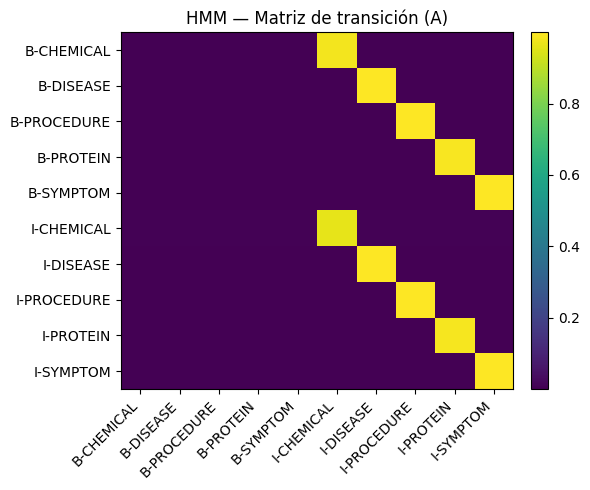

In [100]:
labels = [id2label[i] for i in range(nLabels)]
plt.figure(figsize=(6,5))
plt.imshow(transition, aspect='auto')
plt.title("HMM — Matriz de transición (A)")
plt.xticks(range(nLabels), labels, rotation=45, ha='right')
plt.yticks(range(nLabels), labels)
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

La figura muestra una diagonal muy marcada: las transiciones B-X→I-X e I-X→I-X tienen mayor probabilidad (donde X es cualquier entidad), lo que indica que, una vez que empieza una entidad, el modelo tiende a mantener la misma categoría a lo largo de varios tokens. En cambio, los saltos entre tipos distintos casi no aparecen (celdas oscuras), lo que refleja que en el corpus esos cambios son poco frecuentes. Los valores pequeños fuera de la diagonal se deben al suavizado usado para evitar ceros exactos.

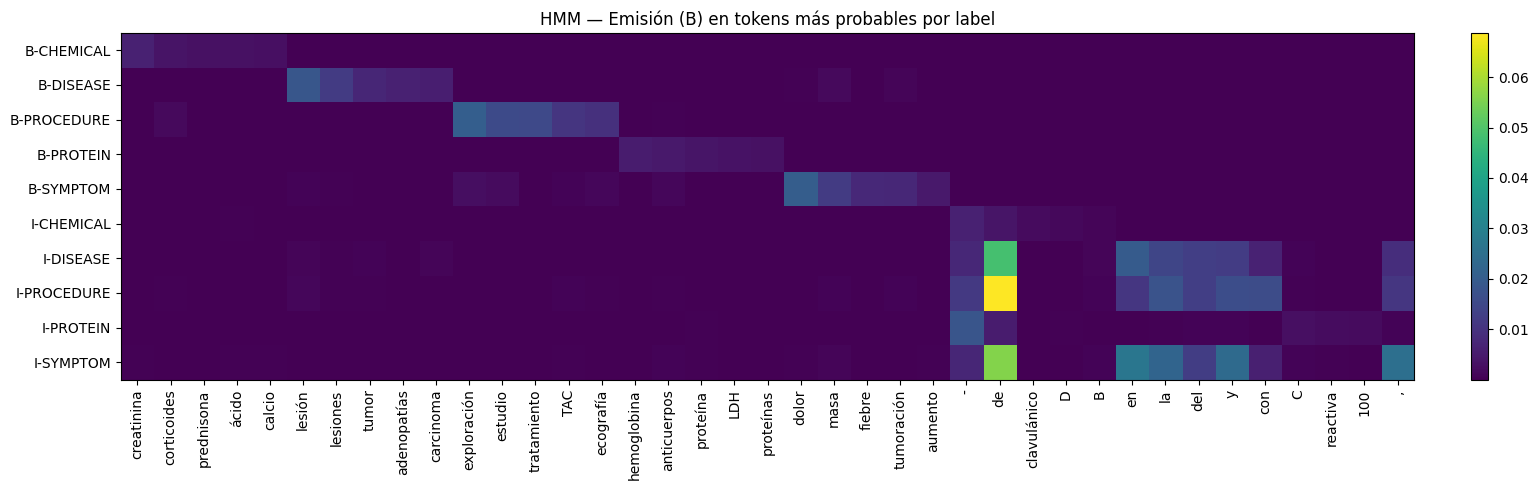

In [101]:
top_k = 5
cols = []
for i in range(nLabels):
    top_idx = np.argsort(emission[i])[::-1][:top_k]
    cols.extend(top_idx.tolist())

seen=set(); cols=[c for c in cols if not (c in seen or seen.add(c))]
E_sub = emission[:, cols]
plt.figure(figsize=(max(10, 0.4*len(cols)), 5))
plt.imshow(E_sub, aspect='auto')
plt.title("HMM — Emisión (B) en tokens más probables por label")
plt.yticks(range(nLabels), [id2label[i] for i in range(nLabels)])
plt.xticks(range(len(cols)), [id2token[j] for j in cols], rotation=90)
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


Al ver la figura, se identifica que el inicio de las entidades suele venir de palabras con alta probabilidad de emisión en el ámbito clínico. Cuando aparece algo como creatinina, tumor, TAC, ecografía o dolor, el modelo casi siempre interpreta que ahí empieza una entidad (en el caso de las etiquetas B). Son términos muy específicos que funcionan como disparadores claros: “dolor de cabeza” arranca en dolor; “exploración física con ecografía” arranca en exploración; “tumoración quística” arranca en tumoración.

En cambio, cuando la entidad sigue (las etiquetas I), lo que más aparece son conectores y palabras de enlace como de, en, la, y, además de guiones y acompañantes que completan la idea. No definen por sí solos la categoría, pero ayudan a sostener la entidad a lo largo de la frase: en “dolor de cabeza”, el de y cabeza prolongan el mismo síntoma, en “exploración física con ecografía”, física, con y ecografía mantienen el mismo procedimiento. 

# Ejercicio 2


In [102]:
def hasDigit(w): return any(ch.isdigit() for ch in w)
def hasPunct(w): return bool(re.search(r"[^\w\s]", w, flags=re.UNICODE))

def wordShape(w):
    out=[]
    for ch in w:
        out.append("X" if ch.isupper() else "x" if ch.islower() else "d" if ch.isdigit() else ch)
    return "".join(out)

def tokenFeatures(sent, i):
    w = sent[i]
    feats = {
        "bias": 1.0,
        "w.lower": w.lower(),
        "w.isupper": w.isupper(),
        "w.istitle": w.istitle(),
        "w.isdigit": w.isdigit(),
        "w.hasDigit": hasDigit(w),
        "w.hasPunct": hasPunct(w),
        "w.prefix2": w[:2].lower(),
        "w.prefix3": w[:3].lower(),
        "w.suffix2": w[-2:].lower(),
        "w.suffix3": w[-3:].lower(),
        "w.shape":  wordShape(w),
    }
    if i > 0:
        w0 = sent[i-1]
        feats.update({
            "-1:w.lower":   w0.lower(),
            "-1:w.istitle": w0.istitle(),
            "-1:w.isupper": w0.isupper(),
            "-1:w.shape":   wordShape(w0),
        })
    if i < len(sent)-1:
        w1 = sent[i+1]
        feats.update({
            "+1:w.lower":   w1.lower(),
            "+1:w.istitle": w1.istitle(),
            "+1:w.isupper": w1.isupper(),
            "+1:w.shape":   wordShape(w1),
        })
    return feats


def buildCrfXY(tokensSeqs, tagsSeqs):
    X = [[tokenFeatures(sent, i) for i in range(len(sent))] for sent in tokensSeqs]
    y = tagsSeqs
    return X, y

XTrain, yTrain = buildCrfXY(tokensTrain, tagsTrain)
XTest,  yTest  = buildCrfXY(tokensTest,  tagsTest)

Para el entrenamiento del CRF primero se definieron características léxicas y contextuales por token: forma en minúsculas, mayúsculas y título; presencia de dígitos y puntuación; prefijos y sufijos (2–3); y la forma (word shape) X/x/d. Además, se incluyó contexto local con los rasgos del token anterior y siguiente.

In [103]:
crf = sklearn_crfsuite.CRF(
    algorithm="lbfgs",
    max_iterations=100,
)
crf.fit(XTrain, yTrain)


,algorithm,'lbfgs'
,min_freq,None
,all_possible_states,None
,all_possible_transitions,None
,c1,None
,c2,None
,max_iterations,100
,num_memories,None
,epsilon,None
,period,None
,delta,None


In [104]:
yPredCRF = crf.predict(XTest)

acc = crf_metrics.flat_accuracy_score(yTest, yPredCRF)
print("Accuracy (token) CRF:", round(acc, 4))

labels = sorted({t for seq in yTrain for t in seq})
print(crf_metrics.flat_classification_report(
    yTest, yPredCRF, labels=labels, digits=3, zero_division=0
))

print("F1 macro:",    round(crf_metrics.flat_f1_score(yTest, yPredCRF, average='macro'), 3))
print("F1 weighted:", round(crf_metrics.flat_f1_score(yTest, yPredCRF, average='weighted'), 3))


Accuracy (token) CRF: 0.8365
              precision    recall  f1-score   support

  B-CHEMICAL      0.859     0.882     0.870      1165
   B-DISEASE      0.807     0.814     0.810      2598
 B-PROCEDURE      0.900     0.892     0.896      3618
   B-PROTEIN      0.876     0.880     0.878       756
   B-SYMPTOM      0.834     0.827     0.830      3102
  I-CHEMICAL      0.707     0.729     0.718       225
   I-DISEASE      0.776     0.766     0.771      6138
 I-PROCEDURE      0.871     0.854     0.862      8045
   I-PROTEIN      0.818     0.862     0.839       390
   I-SYMPTOM      0.830     0.847     0.839      9941

    accuracy                          0.836     35978
   macro avg      0.828     0.835     0.831     35978
weighted avg      0.837     0.836     0.836     35978

F1 macro: 0.831
F1 weighted: 0.836


El CRF obtiene 0.8365 de accuracy a nivel token, con F1 macro = 0.831 y F1 weighted = 0.836. La cercanía entre macro y weighted sugiere que, aunque hay desbalance, no domina el rendimiento global.

Por clase, el modelo es sólido en PROCEDURE y SYMPTOM (p. ej., B-PROCEDURE 0.896, I-PROCEDURE 0.862, I-SYMPTOM 0.839) y también funciona bien en B-CHEMICAL (0.870). En cambio, I-CHEMICAL (0.718) y I-DISEASE (0.771) son los puntos débiles: la baja frecuencia y la ambigüedad contextual reducen el recall y arrastran el F1. El patrón encaja con lo esperado en BIO: el modelo refuerza transiciones B-X→I-X y aprovecha señales léxicas/morfológicas, pero pierde cuando la entidad es larga, rara u ofrece pocas pistas locales.

In [105]:
def show_top_state_features(crf, n=8):
    from collections import defaultdict
    by_label = defaultdict(list)
    for (feat, lab), w in crf.state_features_.items():
        by_label[lab].append((w, feat))
    for lab in sorted(by_label):
        print(f"\n[Label: {lab}]  (Top +{n})")
        for w, feat in sorted(by_label[lab], reverse=True)[:n]:
            print(f"{w:+.3f}  {feat}")

def show_transitions(crf, n=10):
    items = sorted(crf.transition_features_.items(), key=lambda kv: kv[1], reverse=True)
    print("\nTop transiciones (más favorecidas):")
    for (a, b), w in items[:n]:
        print(f"{w:+.3f}  {a} → {b}")
    print("\nBottom transiciones (más penalizadas):")
    for (a, b), w in items[-n:]:
        print(f"{w:+.3f}  {a} → {b}")

show_top_state_features(crf, n=3)
show_transitions(crf, n=3)


[Label: B-CHEMICAL]  (Top +3)
+3.719  w.suffix2:ol
+3.563  w.suffix3:ato
+3.465  bias

[Label: B-DISEASE]  (Top +3)
+3.227  bias
+2.900  w.suffix2:is
+2.697  w.suffix3:tía

[Label: B-PROCEDURE]  (Top +3)
+3.619  w.suffix3:pia
+3.291  bias
+3.237  w.suffix3:ama

[Label: B-PROTEIN]  (Top +3)
+2.802  w.suffix3:mab
+2.753  w.suffix2:ab
+2.730  w.prefix2:ig

[Label: B-SYMPTOM]  (Top +3)
+3.295  bias
+2.587  w.suffix2:ia
+1.891  w.prefix3:dol

[Label: I-CHEMICAL]  (Top +3)
+1.923  -1:w.shape:-
+1.923  -1:w.lower:-
+1.912  -1:w.shape:xx

[Label: I-DISEASE]  (Top +3)
+2.512  -1:w.shape:xx
+1.624  w.suffix2:al
+1.567  -1:w.shape:xxx

[Label: I-PROCEDURE]  (Top +3)
+2.642  -1:w.shape:xx
+1.823  -1:w.shape:xxx
+1.675  -1:w.lower:tratamiento

[Label: I-PROTEIN]  (Top +3)
+2.031  -1:w.shape:xxxxxxx
+1.740  -1:w.shape:xxxxxxxxxx
+1.740  -1:w.shape:-

[Label: I-SYMPTOM]  (Top +3)
+2.970  w.prefix3:neg
+2.307  -1:w.shape:xx
+1.581  w.prefix3:nor

Top transiciones (más favorecidas):
+20.486  I-SYMPTOM

Los pesos nos indican qué patrones usa el CRF para decidir. En los resultados se ve que el modelo aprende terminaciones y comienzos típicos del lenguaje médico: los químicos suelen acabar en -ol o -ato, las proteínas en -mab o con ig- al inicio, muchas enfermedades terminan en -is o -tía, varios procedimientos en -pia o -ama y los síntomas aparecen con -ia o con el comienzo dol-. Esto indica que el modelo está captando la morfología propia de cada categoría.

También se aprecia que, una vez que el texto entra en una entidad, el CRF tiende a continuarla en las palabras siguientes. Lo logra mirando la palabra anterior (por ejemplo, palabras largas, con guiones, o términos como “tratamiento”), lo que refleja que las entidades suelen ocupar varios tokens seguidos. En las transiciones entre etiquetas, las de “seguir igual” (I→I) tienen los pesos más altos, así que el modelo prefiere mantener la misma etiqueta cuando la secuencia lo sugiere. No aparecieron pesos negativos, eso únicamente nos indica que las rutas menos probables quedan menos favorecidas.

# Ejercicio 3

In [106]:

y_true      = list(chain.from_iterable(yTest))
y_pred_hmm  = list(chain.from_iterable(yPredHMM))
y_pred_crf  = list(chain.from_iterable(yPredCRF))

acc_hmm = accuracy_score(y_true, y_pred_hmm)
acc_crf = accuracy_score(y_true, y_pred_crf)

f1_hmm_macro = f1_score(y_true, y_pred_hmm, average="macro", zero_division=0)
f1_crf_macro = f1_score(y_true, y_pred_crf, average="macro", zero_division=0)

print(f"Token accuracy — HMM: {acc_hmm:.4f} | CRF: {acc_crf:.4f}")
print(f"F1 macro       — HMM: {f1_hmm_macro:.3f} | CRF: {f1_crf_macro:.3f}")


Token accuracy — HMM: 0.8177 | CRF: 0.8365
F1 macro       — HMM: 0.781 | CRF: 0.831


In [107]:
pairs_hmm = Counter((t,p) for t,p in zip(y_true, y_pred_hmm) if t!=p)
pairs_crf = Counter((t,p) for t,p in zip(y_true, y_pred_crf) if t!=p)

print("Top confusiones HMM:")
for (t,p),c in pairs_hmm.most_common(10):
    print(f"{t:12s} → {p:12s}  x{c}")

print("\nTop confusiones CRF:")
for (t,p),c in pairs_crf.most_common(10):
    print(f"{t:12s} → {p:12s}  x{c}")

shown_crf_better, shown_hmm_better = 0, 0
for toks, gold, hmm, crf in zip(tokensTest, yTest, yPredHMM, yPredCRF):
    if shown_crf_better < 2 and any(g!=h and g==c for g,h,c in zip(gold,hmm,crf)):
        print("\n[CRF mejor que HMM]")
        print("Tokens:", toks)
        print("Gold  :", gold)
        print("HMM   :", hmm)
        print("CRF   :", crf)
        shown_crf_better += 1
    if shown_hmm_better < 2 and any(g!=c and g==h for g,h,c in zip(gold,hmm,crf)):
        print("\n[HMM mejor que CRF]")
        print("Tokens:", toks)
        print("Gold  :", gold)
        print("HMM   :", hmm)
        print("CRF   :", crf)
        shown_hmm_better += 1
    if shown_crf_better>=2 and shown_hmm_better>=2:
        break


Top confusiones HMM:
I-DISEASE    → I-SYMPTOM     x1333
I-PROCEDURE  → I-SYMPTOM     x854
I-SYMPTOM    → I-DISEASE     x811
I-SYMPTOM    → I-PROCEDURE   x610
B-CHEMICAL   → B-PROCEDURE   x457
I-DISEASE    → I-PROCEDURE   x342
B-DISEASE    → B-SYMPTOM     x329
I-PROCEDURE  → I-DISEASE     x266
B-SYMPTOM    → B-DISEASE     x265
B-DISEASE    → B-PROCEDURE   x244

Top confusiones CRF:
I-DISEASE    → I-SYMPTOM     x1109
I-SYMPTOM    → I-DISEASE     x831
I-SYMPTOM    → I-PROCEDURE   x661
I-PROCEDURE  → I-SYMPTOM     x593
I-PROCEDURE  → I-DISEASE     x516
B-DISEASE    → B-SYMPTOM     x333
B-SYMPTOM    → B-DISEASE     x316
I-DISEASE    → I-PROCEDURE   x315
B-SYMPTOM    → B-PROCEDURE   x182
B-PROCEDURE  → B-SYMPTOM     x145

[HMM mejor que CRF]
Tokens: ['hipertensa']
Gold  : ['B-DISEASE']
HMM   : ['B-DISEASE']
CRF   : ['B-SYMPTOM']

[HMM mejor que CRF]
Tokens: ['polo', 'superior', 'de', 'riñón', 'derecho', 'desplazado', 'hacia', 'abajo']
Gold  : ['B-SYMPTOM', 'I-SYMPTOM', 'I-SYMPTOM', 'I-SYMPTO

Con el mismo split de SPACCC, el HMM obtuvo 0.8177 de exactitud a nivel de token (F1 macro 0.781) y el CRF 0.8365 (F1 macro 0.831). La ganancia del CRF se explica porque aprovecha señales de forma de palabra y contexto inmediato, no solo frecuencias, es decir, toma en cuenta más variables para realizar la asignación a una etiqueta.

Dentro de los errores más comunes, ambos modelos confunden sobre todo entre I-DISEASE e I-SYMPTOM, señal de que, dentro de las entidades, el lenguaje es muy parecido. Aun así, es notable que el CRF reduce varias confusiones: por ejemplo, I-DISEASE→I-SYMPTOM baja de 1333 (HMM) a 1109 y I-PROCEDURE→I-SYMPTOM de 854 a 593. A pesar de esto, el CRF sigue teniendo dificultades  en algunos límites entre B-etiquetas, lo que refleja que distinguir el inicio exacto de la entidad es más difícil.

El HMM muestra ventaja en secuencias largas y continuas, donde su inercia de transición le permite mantener etiquetas consistentes, como en descripciones extensas de síntomas. Sin embargo, se ve limitado al depender solo de emisiones y transiciones. El CRF, en cambio, aprovecha features léxicos y morfológicos, lo que le permite clasificar correctamente entidades específicas del dominio médico, como “marcadores tumorales” o “tumoración quística”. En conjunto, el HMM resulta útil como modelo base en contextos con pocos datos, mientras que el CRF ofrece mayor precisión cuando se dispone de buenas features y vocabulario variado.

De esta forma se puede determinar que el CRF generaliza mejor porque usa features (prefijos/sufijos, minúsculas/mayúsculas, palabra vecina) que le dan una noción incluso con palabras no vistas. El HMM puede ser suficiente cuando se quiere simplicidad, pocos recursos y se trabaja con secuencias cortas o vocabularios más delimiitados. Además, su comportamiento es estable cuando una vez entra a una etiqueta coherente, tiende a sostenerla. Para mejorar más al CRF en este corpus, ayudarían más ejemplos en clases raras y ampliar un poco la ventana de contexto o los rasgos de caracteres.

PoS Tagging Dataset

Se podría repetir el mismo flujo con un dataset de etiquetas gramaticales. Para ello se podría entrenar un HMM y un CRF con features/rasgos simples (si la palabra va en minúsculas o mayúsculas, sus terminaciones y las palabras vecinas) y con ello, se podría comparar usando la precisión. Luego se podrían revisar los errores típicos, por ejemplo confundir sustantivo con nombre propio, o participios que a veces van como verbo y otras como adjetivo. También se podría probar qué pasa cuando hay pocos ejemplos, usar un poco más de contexto alrededor de la palabra y añadir rasgos de caracteres para manejar palabras nuevas no vistas.